# 선형회귀 예시 (1) 

- 다이아몬드 가격에 영향을 미치는 요인


In [1]:
# import sys
# sys.path.append("../../")
# import helper

import numpy as np
from pandas import read_excel, DataFrame, melt, merge
from pca import pca
from pandas.api.types import CategoricalDtype
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from matplotlib import pyplot as plt
import seaborn as sb
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

### 2. 데이터 가져오기

R의 시각화 패키지인 `ggplot2`에 내장되어 있는 데이터셋으로 총 10개의 요인으로 이루어져 있으며 `53,940`개의 관측치가 있다.

| 변수 | 의미 | 기타 |
|---|---|---|
| carat | 무게 | ex) 3캐럿짜리 다이아몬드 |
| cut | 세공의 질 | 다이아몬드의 단면을 어떻게 커팅하였는지에 대한 상태값을 분류<br/>'계층이 있는 범주형(factor)' 데이터<br/>"Fair", "Good", "Very Good", "Premium", "Ideal"로 나누어진다. |
| color | 컬러 | 총 7개의 컬러로 표기된 범주형 데이터<br/>
| clarity | 투명도 | 범주형 데이터 |
| depth | 깊이 | 수치형 데이터 |
| table | 넓은 폭 대비 꼭대기의 넓이 | 수치형 데이터 |
| price | 가격(`$`) | 수치형 데이터 |
| x | 길이 | 수치형 데이터 |
| y | 넓이 | 수치형 데이터 |
|  z | 깊이 | 수치형 데이터 |

In [2]:
origin = read_excel("https://data.hossam.kr/E04/diamonds.xlsx")
origin

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


## #02. 데이터 전처리

### 1. 데이터프레임 복사

In [3]:
edf = origin.copy()
edf.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### 2. 결측치 확인

In [4]:
edf.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

### 3. 데이터 타입 확인

In [5]:
edf.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

### 4. 일단 분석

#### 1) 회귀분석

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas import DataFrame, MultiIndex, concat, DatetimeIndex


class OlsResult:
    def __init__(self):
        self._model = None
        self._fit = None
        self._summary = None
        self._table = None
        self._result = None
        self._goodness = None
        self._varstr = None

    @property
    def model(self):
        """
        분석모델
        """
        return self._model

    @model.setter
    def model(self, value):
        self._model = value

    @property
    def fit(self):
        """
        분석결과 객체
        """
        return self._fit

    @fit.setter
    def fit(self, value):
        self._fit = value

    @property
    def summary(self):
        """
        분석결과 요약 보고
        """
        return self._summary

    @summary.setter
    def summary(self, value):
        self._summary = value

    @property
    def table(self):
        """
        결과표
        """
        return self._table

    @table.setter
    def table(self, value):
        self._table = value

    @property
    def result(self):
        """
        결과표 부가 설명
        """
        return self._result

    @result.setter
    def result(self, value):
        self._result = value

    @property
    def goodness(self):
        """
        모형 적합도 보고
        """
        return self._goodness

    @goodness.setter
    def goodness(self, value):
        self._goodness = value

    @property
    def varstr(self):
        """
        독립변수 보고
        """
        return self._varstr

    @varstr.setter
    def varstr(self, value):
        self._varstr = value

        
def myOls(data, y, x):
    """
    회귀분석을 수행한다.

    Parameters
    -------
    - data : 데이터 프레임
    - y: 종속변수 이름
    - x: 독립변수의 이름들(리스트)
    """

    # 독립변수의 이름이 리스트가 아니라면 리스트로 변환
    if type(x) != list:
        x = [x]

    # 종속변수~독립변수1+독립변수2+독립변수3+... 형태의 식을 생성
    expr = "%s~%s" % (y, "+".join(x))

    # 회귀모델 생성
    model = ols(expr, data=data)
    # 분석 수행
    fit = model.fit()

    # 파이썬 분석결과를 변수에 저장한다.
    summary = fit.summary()

    # 첫 번째, 세 번째 표의 내용을 딕셔너리로 분해
    my = {}

    for k in range(0, 3, 2):
        items = summary.tables[k].data
        # print(items)

        for item in items:
            # print(item)
            n = len(item)

            for i in range(0, n, 2):
                key = item[i].strip()[:-1]
                value = item[i+1].strip()

                if key and value:
                    my[key] = value

    # 두 번째 표의 내용을 딕셔너리로 분해하여 my에 추가
    my['variables'] = []
    name_list = list(data.columns)
    #print(name_list)

    for i, v in enumerate(summary.tables[1].data):
        if i == 0:
            continue

        # 변수의 이름
        name = v[0].strip()

        vif = 0

        # Intercept는 제외
        if name in name_list:
            # 변수의 이름 목록에서 현재 변수가 몇 번째 항목인지 찾기 
            j = name_list.index(name)
            vif = variance_inflation_factor(data, j)

        my['variables'].append({
            "name": name,
            "coef": v[1].strip(),
            "std err": v[2].strip(),
            "t": v[3].strip(),
            "P-value": v[4].strip(),
            "Beta": 0,
            "VIF": vif,
        })

    # 결과표를 데이터프레임으로 구성
    mylist = []
    yname_list = []
    xname_list = []

    for i in my['variables']:
        if i['name'] == 'Intercept':
            continue

        yname_list.append(y)
        xname_list.append(i['name'])

        item = {
            "B": i['coef'],
            "표준오차": i['std err'],
            "β": i['Beta'],
            "t": "%s*" % i['t'],
            "유의확률": i['P-value'],
            "VIF": i["VIF"]
        }

        mylist.append(item)

    table = DataFrame(mylist,
                   index=MultiIndex.from_arrays([yname_list, xname_list], names=['종속변수', '독립변수']))
    
    # 분석결과
    result = "𝑅(%s), 𝑅^2(%s), 𝐹(%s), 유의확률(%s), Durbin-Watson(%s)" % (my['R-squared'], my['Adj. R-squared'], my['F-statistic'], my['Prob (F-statistic)'], my['Durbin-Watson'])

    # 모형 적합도 보고
    goodness = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p < 0.05)." % (y, ",".join(x), "유의하다" if float(my['Prob (F-statistic)']) < 0.05 else "유의하지 않다", my['Df Model'], my['Df Residuals'], my['F-statistic'])

    # 독립변수 보고
    varstr = []

    for i, v in enumerate(my['variables']):
        if i == 0:
            continue
        
        s = "%s의 회귀계수는 %s(p%s0.05)로, %s에 대하여 %s."
        k = s % (v['name'], v['coef'], "<" if float(v['P-value']) < 0.05 else '>', y, '유의미한 예측변인인 것으로 나타났다' if float(v['P-value']) < 0.05 else '유의하지 않은 예측변인인 것으로 나타났다')

        varstr.append(k)

    ols_result = OlsResult()
    ols_result.model = model
    ols_result.fit = fit
    ols_result.summary = summary
    ols_result.table = table
    ols_result.result = result
    ols_result.goodness = goodness
    ols_result.varstr = varstr

    return ols_result

In [7]:
tmp = edf.filter(['carat', 'depth', 'table', 'x', 'y', 'z', 'price'])

ols_result = myOls(tmp, y='price', x=['carat', 'depth', 'table', 'x', 'y', 'z'])
print(ols_result.summary)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 5.486e+04
Date:                Thu, 10 Aug 2023   Prob (F-statistic):               0.00
Time:                        11:33:37   Log-Likelihood:            -4.7090e+05
No. Observations:               53940   AIC:                         9.418e+05
Df Residuals:                   53933   BIC:                         9.419e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.085e+04    447.562     46.584      0.0

Durbin-Watson 통계량은 회귀분석 모델에서 자기상관(autocorrelation)을 평가하는 데 사용되는 중요한 도구입니다. 자기상관은 오차항(residuals) 간에 시간적 또는 순서적인 연관성이 있는지를 나타내는데, 회귀분석 모델에서는 이를 무시하면 잘못된 결과를 얻을 수 있습니다.

Durbin-Watson 통계량은 주로 시계열 데이터나 패널 데이터 등 순서가 있는 데이터에서 사용됩니다. 이 통계량은 오차항의 자기상관을 평가하기 위해 회귀분석의 잔차(residuals)를 사용하여 계산됩니다. Durbin-Watson 통계량의 값은 0에서 4 사이에 있으며, 일반적으로 다음과 같은 의미를 가집니다:

Durbin-Watson 값이 2에 가까울 경우: 자기상관이 없거나 매우 약한 상태로 간주됩니다.
Durbin-Watson 값이 0에 가까울 경우: 양의 자기상관이 강한 상태로 간주됩니다.
Durbin-Watson 값이 4에 가까울 경우: 음의 자기상관이 강한 상태로 간주됩니다.
Durbin-Watson 통계량의 중요한 점은 값이 2 주위에 있는 경우, 자기상관이 없거나 약하다고 가정하여 회귀모델이 적절하게 작동할 가능성이 높습니다. 하지만 값이 2에서 크게 벗어나는 경우에는 오차항 간에 강한 자기상관이나 반대로 자기상관이 부적절하게 작용할 수 있음을 나타냅니다. 이 경우 추가적인 조치가 필요할 수 있습니다.

따라서 Durbin-Watson 통계량은 회귀분석 모델의 신뢰성을 평가하고 모델이 잔차들 사이에서 자기상관을 가지는지를 확인하는 데 사용되는 유용한 도구입니다.



#### 결과보고

In [8]:
ols_result.table

print(ols_result.result, end="\n\n")
print(ols_result.goodness, end="\n\n")
for i in ols_result.varstr:
    print(i)

𝑅(0.859), 𝑅^2(0.859), 𝐹(5.486e+04), 유의확률(0.00), Durbin-Watson(1.249)

price에 대하여 carat,depth,table,x,y,z로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(6,53933) = 5.486e+04, p < 0.05).

carat의 회귀계수는 1.069e+04(p<0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
depth의 회귀계수는 -203.1541(p<0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
table의 회귀계수는 -102.4457(p<0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
x의 회귀계수는 -1315.6678(p<0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
y의 회귀계수는 66.3216(p<0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
z의 회귀계수는 41.6277(p>0.05)로, price에 대하여 유의하지 않은 예측변인인 것으로 나타났다.


#### 3) 잔차분석

##### 결과치 생성

In [9]:
sdf = DataFrame({
    "관측값": edf['price'],
    "예측값": ols_result.fit.fittedvalues,
    "잔차": ols_result.fit.resid,
    "zscore": stats.zscore(ols_result.fit.fittedvalues)
})

sdf

,관측값,예측값,잔차,zscore
0,326,346.909718,-20.909718,-0.969700
1,326,-71.468765,397.468765,-1.082838
2,327,126.368674,200.631326,-1.029339
3,334,193.901639,140.098361,-1.011076
4,335,53.549591,281.450409,-1.049030
...,...,...,...,...
53935,2757,3314.909673,-557.909673,-0.167090
53936,2757,3135.402558,-378.402558,-0.215633
53937,2757,2503.140469,253.859531,-0.386610
53938,2757,4175.515769,-1418.515769,0.065635


#### 잔차의 정규성 

##### Q-Q Plot
qqplot 잔차들이 일직선상에 모여있는지 확인

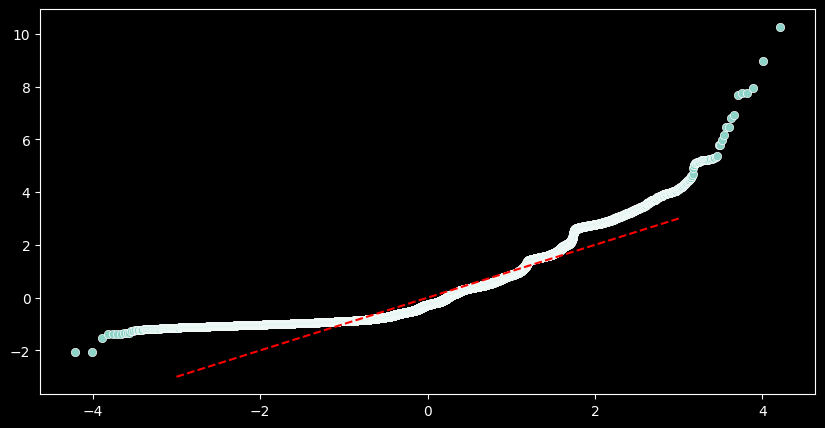

In [10]:
(x, y), _ = stats.probplot(sdf['zscore'])

plt.figure(figsize=(10, 5))
sb.scatterplot(x=x, y=y)
sb.lineplot(x=[-3, 3], y=[-3, 3], color='red', linestyle='--')
plt.show()
plt.close()

##### 정규성 판단을 위한 Kolmogorov Smirnov 검정

표본 수가 50개 이상인 경우 사용

(샤피로 검정은 표본 수가 50개 미만일 때 사용함)

In [11]:
s, p = stats.kstest(sdf['잔차'], 'norm')
print("Kolmogorov Smirnov Test: (통계량, p-value) = ", (s, p))

if p > 0.05:
    print("잔차는 정규 분포를 따릅니다. (귀무가설 채택)")
else:
    print("잔차는 정규 분포를 따르지 않습니다. (귀무가설 기각)")

Kolmogorov Smirnov Test: (통계량, p-value) =  (0.5298424160387368, 0.0)
잔차는 정규 분포를 따르지 않습니다. (귀무가설 기각)


#### 잔차의 등분산성 (브로이슈 패건 검정)

In [12]:
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test_result = het_breuschpagan(ols_result.fit.resid, ols_result.fit.model.exog)
DataFrame(test_result, index=names)

,0
Lagrange multiplier statistic,9934.176446
p-value,0.000000
f-value,2029.200891
f p-value,0.000000


> 각종 검정 결과를 종합하여 분석 결과를 신뢰할 수 없는 것으로 판단하고 재시도.

### 4. 범주형 타입 변환

#### 1) 순서 있는 범주형 설정

In [13]:
ctype = CategoricalDtype(categories=["Fair", "Good", "Very Good", "Premium", "Ideal"], ordered=True)

edf['cut'] = edf['cut'].astype(ctype)
edf.dtypes

carat       float64
cut        category
color        object
clarity      object
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object

#### 2) 순서 없는 범주형 설정

In [14]:
edf['color'] = edf['color'].astype('category')
edf['clarity'] = edf['clarity'].astype('category')
edf.dtypes

carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object

## #03. 요인선정을 위한 탐색적 데이터 분석

### 1. 수치형 변수

#### 1) 기초 통계량 확인

범주형 데이터는 자동으로 제외된다.

In [15]:
desc = edf.describe()
desc

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


#### 2) 상자그림 확인

##### 일괄처리

범주형 변수는 자동으로 제외된다.

종속변수인 가격(`price`)를 제외하고는 비슷한 범위를 갖고 있으므로 표준화는 불필요한 것으로 판단

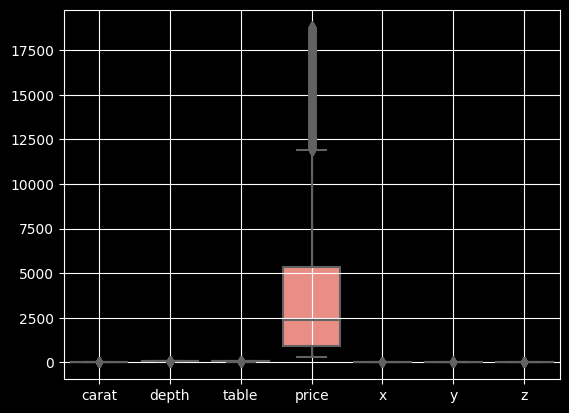

In [16]:
sb.boxplot(data=edf)
plt.grid()
plt.show()
plt.close()

##### 개별 컬럼에 대한 상자그림

범주형을 제외하고 처리해야 하므로 `desribe()` 함수의 결과로 생성된 데이터프레임의 컬럼명에 대해서만 처리한다.

이상치가 다수 관측되지만 실제 데이터인 것으로 판단하고 정제하지 않기로 함

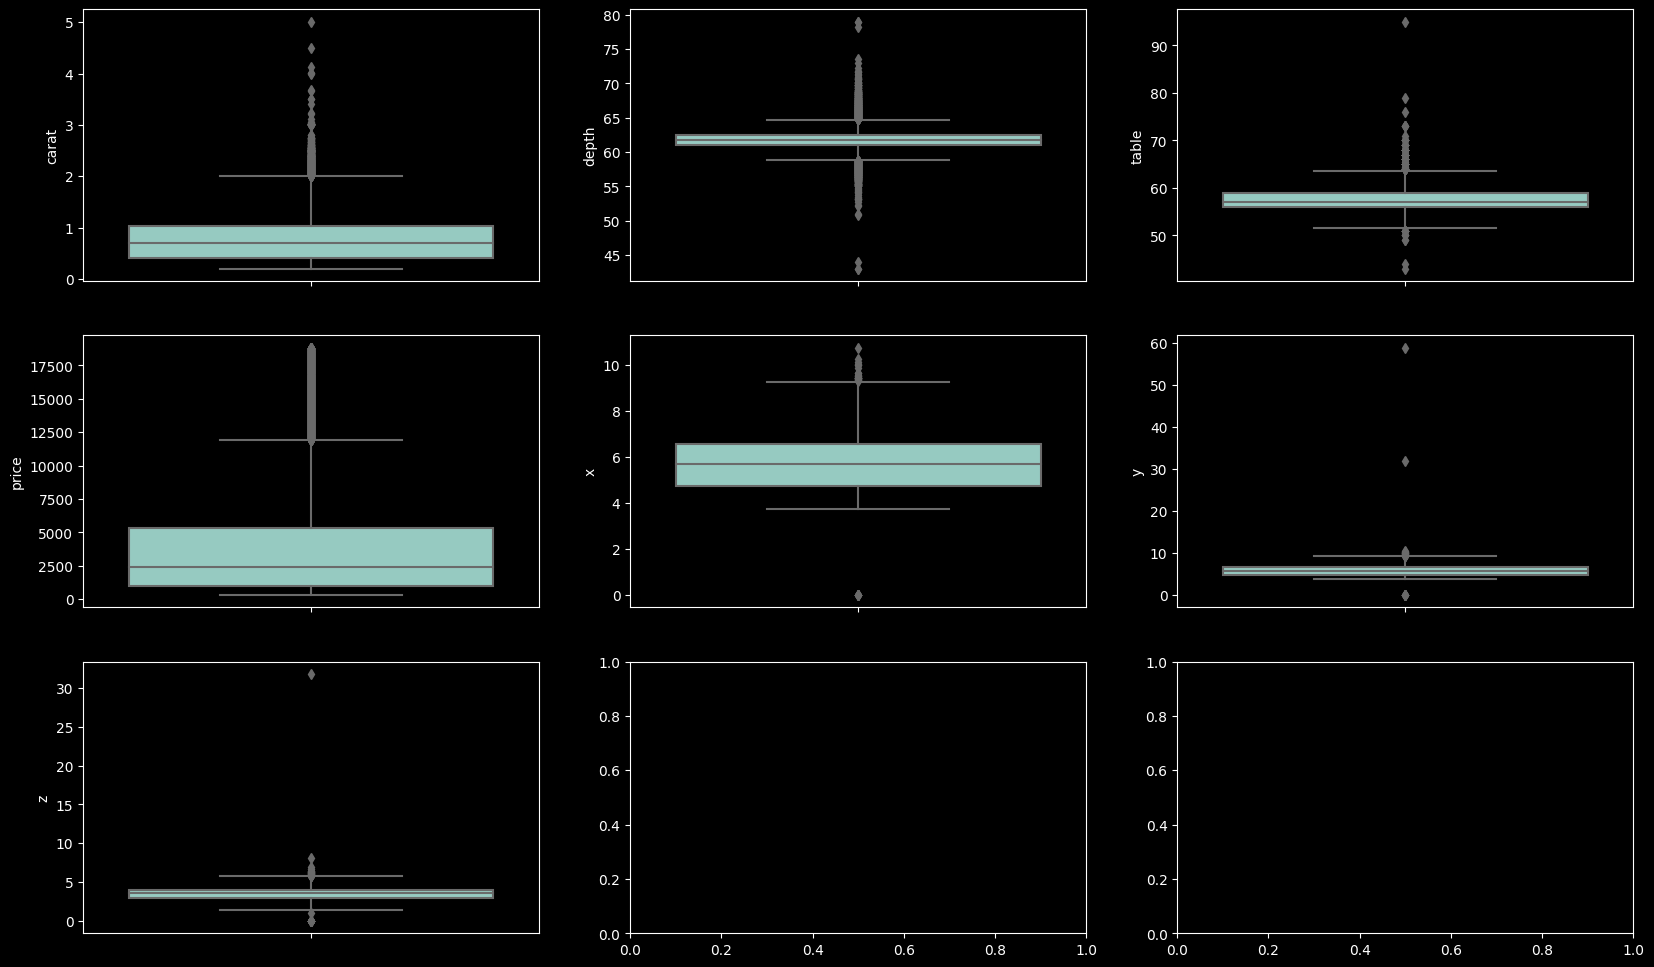

In [17]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
rows = len(ax)
cols = len(ax[0])

for i in range(0, rows):
    for j in range(0, cols):
        idx = i * cols + j
        sb.boxplot(edf, y=desc.columns[idx], ax=ax[i][j])
        
        if idx+1 == len(desc.columns):
            break

plt.show()
plt.close()

#### 3) 산점도 행렬 확인

요인간의 자기상관관계를 확인하기 위해 산점도 행렬을 확인한다.

##### 범주형이 아닌 컬럼이름만 추출

In [18]:
cnames = []
dtypes = edf.dtypes

for i, v in enumerate(dtypes):
    if v != 'category':
        print(dtypes.index[i], dtypes[i])
        cnames.append(dtypes.index[i])
        
print(cnames)

carat float64
depth float64
table float64
price int64
x float64
y float64
z float64
['carat', 'depth', 'table', 'price', 'x', 'y', 'z']


##### 추출한 필드에 대한 산점도 행렬

> 다소 시간이 오래 걸린다.

일부 요인들 간에 상관관계가 발견된다.

<Figure size 3000x2000 with 0 Axes>

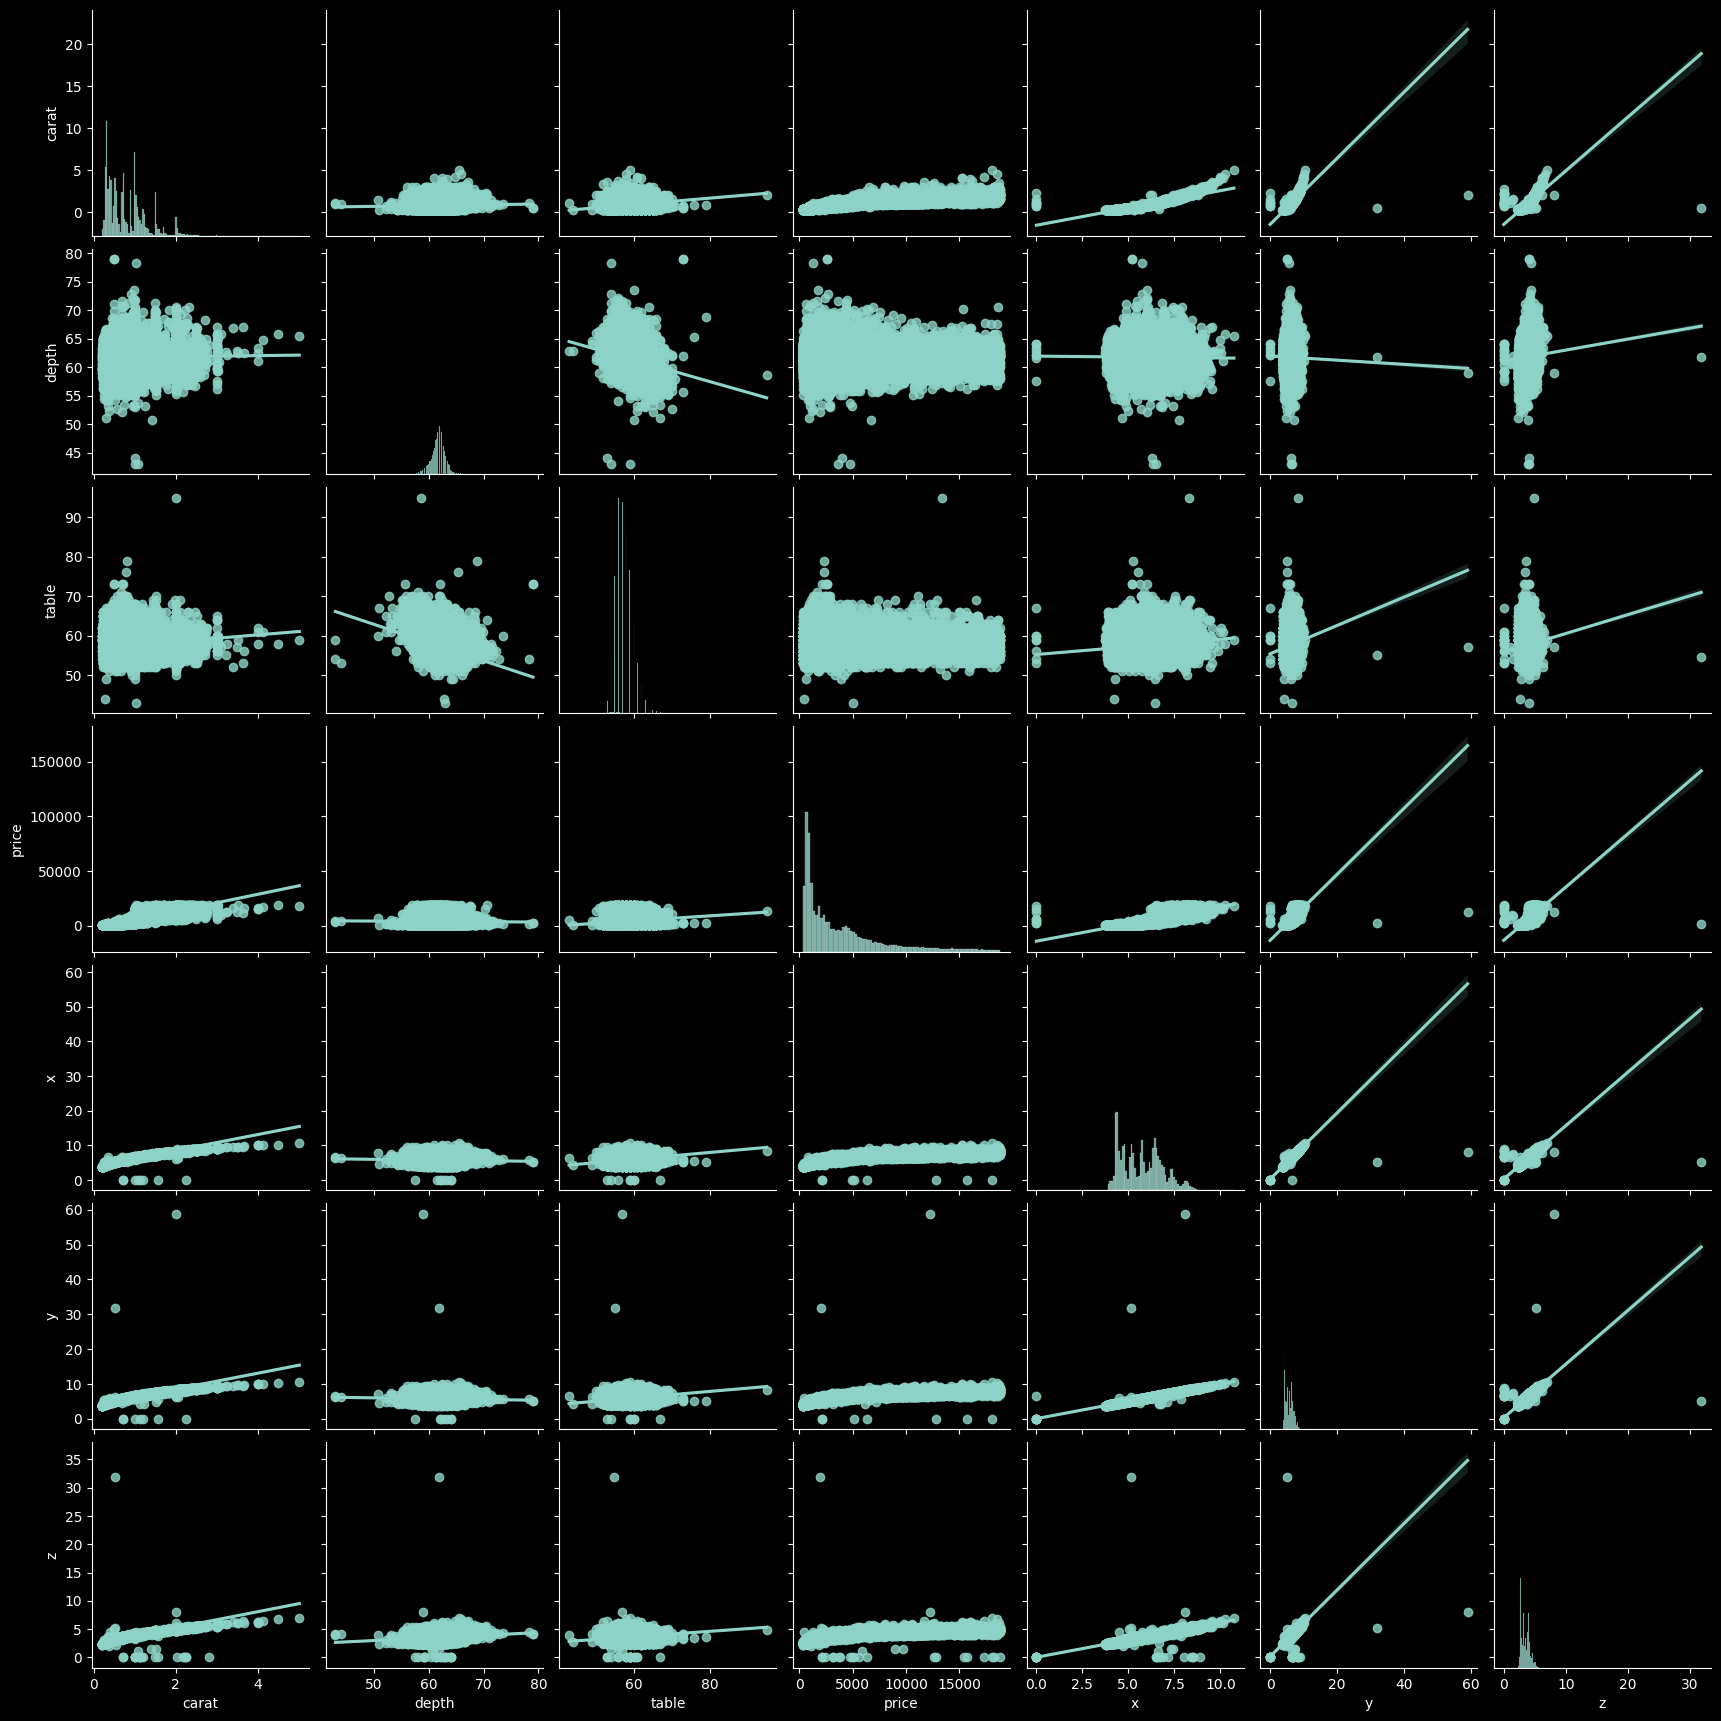

In [19]:
plt.figure(figsize=(30, 20))
sb.pairplot(data=edf, vars=cnames, kind='reg')
plt.show()
plt.close()

#### 4) PCA 분석

회귀분석에 필요한 요인들을 선정하기 위해 주성분 분석을 수행한다.

##### 데이터 표준화

범주형은 PCA를 수행할 수 없기 때문에 `edf`에서 수치형 변수만 추출하여 처리한다.

종속 변수인 가격은 제외하고 진행한다.

In [20]:
from sklearn.preprocessing import StandardScaler


def replaceOutlier(df, fieldName):
    """
    이상치를 판별하여 결측치로 치환

    Parameters
    -------
    - df: 데이터 프레임
    - fieldName: 이상치를 판별할 필드명

    Returns
    -------
    - cdf : 결측치를 이상치로 치환한 데이터 프레임
    """
    cdf = df.copy()

    # fieldName이 List가 아니면 List로 변환
    if not isinstance(fieldName, list):
        fieldName = [fieldName]

    for f in fieldName:
        결측치경계 = getIq(cdf[f])
        cdf.loc[cdf[f] < 결측치경계[0], f] = np.nan
        cdf.loc[cdf[f] > 결측치경계[1], f] = np.nan

    return cdf

def replaceMissingValue(df, strategy='mean'):
    """
    결측치 정제

    Parameters
    -------
    - df: 데이터 프레임
    - strategy: 결측치 대체 전략(mean, median, most_frequent). 기본값은 mean

    Returns
    -------
    - re_df: 정제된 데이터 프레임
    """
    imr = SimpleImputer(missing_values=np.nan, strategy=strategy)
    df_imr = imr.fit_transform(df.values)
    re_df = DataFrame(df_imr, index=df.index, columns=df.columns)
    return re_df
def scalling(df, yname=None):
    """
    데이터 프레임을 표준화 한다.

    Parameters
    -------
    - df: 데이터 프레임
    - yname: 종속변수 이름

    Returns
    -------
    - x_train_std_df: 표준화된 독립변수 데이터 프레임
    - y_train_std_df: 표준화된 종속변수 데이터 프레임
    """
    # 평소에는 yname을 제거한 항목을 사용
    # yname이 있지 않다면 df를 복사
    x_train = df.drop([yname], axis=1) if yname else df.copy()
    x_train_std = StandardScaler().fit_transform(x_train)
    x_train_std_df = DataFrame(x_train_std, columns=x_train.columns)
    
    if yname:
        y_train = df.filter([yname])
        y_train_std = StandardScaler().fit_transform(y_train)
        y_train_std_df = DataFrame(y_train_std, columns=y_train.columns)

    if yname:
        result = (x_train_std_df, y_train_std_df)
    else:
        result = x_train_std_df

    return result

In [21]:
x_train_std_df, y_train_std_df = scalling(edf[cnames], 'price')
x_train_std_df

,carat,depth,table,x,y,z
0,-1.198168,-0.174092,-1.099672,-1.587837,-1.536196,-1.571129
1,-1.240361,-1.360738,1.585529,-1.641325,-1.658774,-1.741175
2,-1.198168,-3.385019,3.375663,-1.498691,-1.457395,-1.741175
3,-1.071587,0.454133,0.242928,-1.364971,-1.317305,-1.287720
4,-1.029394,1.082358,0.242928,-1.240167,-1.212238,-1.117674
...,...,...,...,...,...,...
53935,-0.164427,-0.662711,-0.204605,0.016798,0.022304,-0.054888
53936,-0.164427,0.942753,-1.099672,-0.036690,0.013548,0.100988
53937,-0.206621,0.733344,1.137995,-0.063434,-0.047741,0.030135
53938,0.130927,-0.523105,0.242928,0.373383,0.337506,0.285204


##### PCA

In [22]:
model = pca()
# 표준화 결과를 활용하여 주성분 분석 수행
fit = model.fit_transform(x_train_std_df)
topfeat = fit['topfeat']
topfeat

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [6] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [3] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [6] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


,PC,feature,loading,type
0,PC1,x,0.500910,best
1,PC2,depth,-0.734082,best
2,PC3,table,0.732523,best
3,PC1,carat,0.495367,weak
4,PC1,y,0.495218,weak
5,PC1,z,0.493882,weak


##### 주성분 선정

In [23]:
best = topfeat.query("type=='best'")
best_names = list(set(list(best['feature'])))
best_names

['x', 'table', 'depth']

### 2. 범주형 변수

#### 범주형만 추출

In [24]:
cnames = []
dtypes = edf.dtypes

for i, v in enumerate(dtypes):
    if v == 'category':
        print(dtypes.index[i], dtypes[i])
        cnames.append(dtypes.index[i])
        
print(cnames)

cut category
color category
clarity category
['cut', 'color', 'clarity']


#### 범주형 데이터 분포 확인

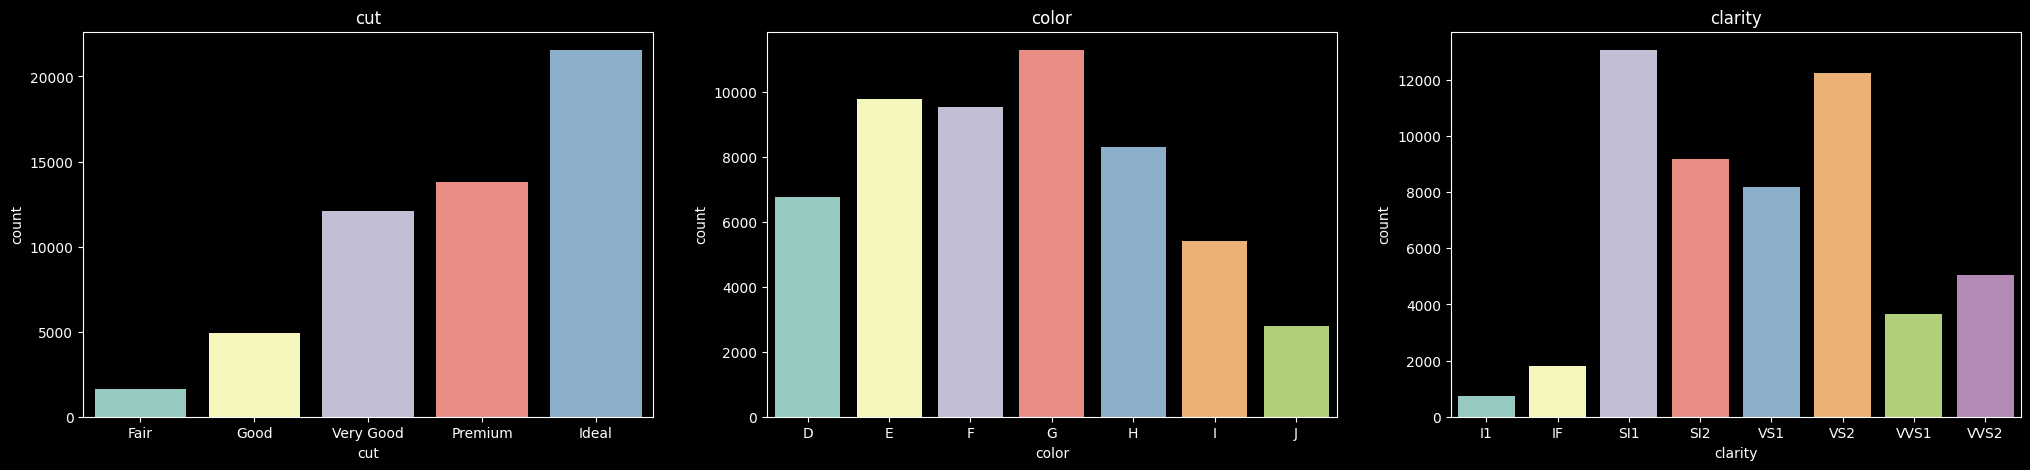

In [25]:
fig, ax = plt.subplots(1, len(cnames), figsize=(25, 5))

for i, v in enumerate(cnames):
    vc = DataFrame(edf[v].value_counts(), columns=['count'])
    #print(vc)
    sb.barplot(data=vc, x=vc.index, y='count', ax=ax[i])
    ax[i].set_title(v)
    
plt.show()
plt.close()

#### `cut` 변수에 대한 분산분석

##### 데이터 타입 확인

범주형이다.

In [26]:
edf['cut'].dtypes

CategoricalDtype(categories=['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], ordered=True)

##### 범주형 변수의 종류 추출

In [27]:
edf['cut'].dtypes.categories

Index(['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'], dtype='object')

##### 범주형 변수에 대한 라벨링 값 생성

In [28]:
mydict = {}

for i, v in enumerate(edf['cut'].dtypes.categories):
    mydict[v] = i
    
mydict

{'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}

##### 라벨링 처리

In [29]:
tmp_df = edf.filter(['price', 'cut'])
tmp_df['cut'] = tmp_df['cut'].map(mydict).astype('int')
tmp_df

,price,cut
0,326,4
1,326,3
2,327,1
3,334,3
4,335,1
...,...,...
53935,2757,4
53936,2757,1
53937,2757,2
53938,2757,3


##### 분산분석에 대한 적합성 검정

조건을 충족하지 않으므로 이 요인은 제외하는 것으로 결정한다.

In [44]:
from scipy.stats import shapiro, normaltest, ks_2samp, bartlett, fligner, levene, chi2_contingency
from tabulate import tabulate

def prettyPrint(df, headers="keys", tablefmt="psql", numalign="right"):
    print(tabulate(df, headers=headers, tablefmt=tablefmt, numalign=numalign))

def normalityTest(*any, isPrint=True):
    """
    분산분석을 수행하기 위한 정규성을 검정 한다.

    Parameters
    -------
    - any: 필드들

    Returns
    -------
    - df: 검정 결과 데이터 프레임
    """
    names = []

    result = {
        'field': [],
        'test': [],
        'statistic': [],
        'p-value': [],
        'result': []
    }
    for i in any:
        s, p = shapiro(i)
        result['field'].append(i.name)
        result['test'].append('shapiro')
        result['statistic'].append(s)
        result['p-value'].append(p)
        result['result'].append(p > 0.05)
        names.append('정규성')

    for i in any:
        s, p = normaltest(i)
        result['field'].append(i.name)
        result['test'].append('shapiro')
        result['statistic'].append(s)
        result['p-value'].append(p)
        result['result'].append(p > 0.05)
        names.append('정규성')

    n = len(any)

    for i in range(0, n):
        j = i + 1 if i < n - 1 else 0

        s, p = ks_2samp(any[i], any[j])
        result['field'].append(f'{any[i].name} vs {any[j].name}')
        result['test'].append('ks_2samp')
        result['statistic'].append(s)
        result['p-value'].append(p)
        result['result'].append(p > 0.05)
        names.append('정규성')

    rdf = DataFrame(result, index=names)

    if isPrint:
        prettyPrint(rdf)
    else:
        return rdf


def equalVarianceTest(*any, isPrint=True):
    """
    분산분석을 수행하기 위한 등분산성을 검정 한다.

    Parameters
    -------
    - any: 필드들

    Returns
    -------
    - df: 검정 결과 데이터 프레임
    """
    s1, p1 = bartlett(*any)
    s2, p2 = fligner(*any)
    s3, p3 = levene(*any)

    names = []

    for i in any:
        names.append(i.name)

    fix = " vs "
    name = fix.join(names)
    index = ['등분산성', '등분산성', '등분산성']

    df = DataFrame({
        'field': [name, name, name],
        'test': ['Bartlett', 'Fligner', 'Levene'],
        'statistic': [s1, s2, s3],
        'p-value': [p1, p2, p3],
        'result': [p1 > 0.05, p2 > 0.05, p3 > 0.05]
    }, index=index)

    if isPrint:
        prettyPrint(df)
    else:
        return df


def independenceTest(*any, isPrint=True):
    """
    분산분석을 수행하기 위한 독립성을 검정한다.

    Parameters
    -------
    - any: 필드들

    Returns
    -------
    - df: 검정 결과 데이터 프레임
    """
    df = DataFrame(any).T
    result = chi2_contingency(df)

    names = []

    for i in any:
        names.append(i.name)

    fix = " vs "
    name = fix.join(names)

    index = ['독립성']

    df = DataFrame({
        'field': [name],
        'test': ['Chi2'],
        'statistic': [result.statistic],
        'p-value': [result.pvalue],
        'result': [result.pvalue > 0.05]
    }, index=index)

    if isPrint:
        prettyPrint(df)
    else:
        return df

def allTest(*any, isPrint=True):
    """
    정규성, 등분산성, 독립성을 모두 검정한다.

    Parameters
    -------
    - any: 필드들

    Returns
    -------
    - df: 검정 결과 데이터 프레임
    """
    cc = concat([normalityTest(*any, isPrint=False), equalVarianceTest(*any, isPrint=False), independenceTest(*any, isPrint=False)])

    if isPrint:
        prettyPrint(cc)
    else:
        return cc

In [45]:
allTest(tmp_df['price'], tmp_df['cut'])

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


+----------+--------------+----------+-------------+-----------+----------+
|          | field        | test     |   statistic |   p-value | result   |
|----------+--------------+----------+-------------+-----------+----------|
| 정규성   | price        | shapiro  |    0.798108 |         0 | False    |
| 정규성   | cut          | shapiro  |    0.840702 |         0 | False    |
| 정규성   | price        | shapiro  |     15096.6 |         0 | False    |
| 정규성   | cut          | shapiro  |     4332.54 |         0 | False    |
| 정규성   | price vs cut | ks_2samp |           1 |         0 | False    |
| 정규성   | cut vs price | ks_2samp |           1 |         0 | False    |
| 등분산성 | price vs cut | Bartlett |      807780 |         0 | False    |
| 등분산성 | price vs cut | Fligner  |     67384.1 |         0 | False    |
| 등분산성 | price vs cut | Levene   |     40950.1 |         0 | False    |
| 독립성   | price vs cut | Chi2     |      324145 |         0 | False    |
+----------+--------------+----------+-------

#### `color` 변수에 대한 검정

In [46]:
yname = 'price'
xname = 'color'
mydict = {}

for i, v in enumerate(edf[xname].dtypes.categories):
    mydict[v] = i
#mydict

tmp_df = edf.filter([yname, xname])
tmp_df[xname] = tmp_df[xname].map(mydict).astype('int')
#tmp_df

allTest(tmp_df[yname], tmp_df[xname])

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


+----------+----------------+----------+-------------+-----------+----------+
|          | field          | test     |   statistic |   p-value | result   |
|----------+----------------+----------+-------------+-----------+----------|
| 정규성   | price          | shapiro  |    0.798108 |         0 | False    |
| 정규성   | color          | shapiro  |    0.940571 |         0 | False    |
| 정규성   | price          | shapiro  |     15096.6 |         0 | False    |
| 정규성   | color          | shapiro  |      6626.9 |         0 | False    |
| 정규성   | price vs color | ks_2samp |           1 |         0 | False    |
| 정규성   | color vs price | ks_2samp |           1 |         0 | False    |
| 등분산성 | price vs color | Bartlett |      762365 |         0 | False    |
| 등분산성 | price vs color | Fligner  |     66621.1 |         0 | False    |
| 등분산성 | price vs color | Levene   |     40934.5 |         0 | False    |
| 독립성   | price vs color | Chi2     |      334347 |         0 | False    |
+----------+-------

#### `clarity` 변수에 대한 검정

In [47]:
yname = 'price'
xname = 'clarity'
mydict = {}

for i, v in enumerate(edf[xname].dtypes.categories):
    mydict[v] = i
#mydict

tmp_df = edf.filter([yname, xname])
tmp_df[xname] = tmp_df[xname].map(mydict).astype('int')
#tmp_df

allTest(tmp_df[yname], tmp_df[xname])

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


+----------+------------------+----------+-------------+-----------+----------+
|          | field            | test     |   statistic |   p-value | result   |
|----------+------------------+----------+-------------+-----------+----------|
| 정규성   | price            | shapiro  |    0.798108 |         0 | False    |
| 정규성   | clarity          | shapiro  |    0.935033 |         0 | False    |
| 정규성   | price            | shapiro  |     15096.6 |         0 | False    |
| 정규성   | clarity          | shapiro  |     5334.54 |         0 | False    |
| 정규성   | price vs clarity | ks_2samp |           1 |         0 | False    |
| 정규성   | clarity vs price | ks_2samp |           1 |         0 | False    |
| 등분산성 | price vs clarity | Bartlett |      760886 |         0 | False    |
| 등분산성 | price vs clarity | Fligner  |     66703.3 |         0 | False    |
| 등분산성 | price vs clarity | Levene   |     40933.8 |         0 | False    |
| 독립성   | price vs clarity | Chi2     |      492832 |         0 | Fals

## #04. 회귀분석 수행

### 1. 최종 요인 선정

검정 결과 범주형 변수는 정규성, 등분산성, 독립성을 충족하지 않기 때문에 요인에서 제외하였다.

그러므로 최초에 생성했던 수치형 변수들에 대한 표준화 결과로만 구성된 데이터프레임을 만들었다.

그 후 생성된 데이터 프레임에서 PCA 분석 결과로 선정된 독립변수들과 종속변수만 추출하였다.

In [48]:
best_names

['x', 'table', 'depth']

In [49]:
target_names = best_names + ['price']
target_names

['x', 'table', 'depth', 'price']

In [50]:
merge_df = merge(x_train_std_df, y_train_std_df, left_index=True, right_index=True)
df = merge_df.filter(target_names)
df

,x,table,depth,price
0,-1.587837,-1.099672,-0.174092,-0.904095
1,-1.641325,1.585529,-1.360738,-0.904095
2,-1.498691,3.375663,-3.385019,-0.903844
3,-1.364971,0.242928,0.454133,-0.902090
4,-1.240167,0.242928,1.082358,-0.901839
...,...,...,...,...
53935,0.016798,-0.204605,-0.662711,-0.294731
53936,-0.036690,-1.099672,0.942753,-0.294731
53937,-0.063434,1.137995,0.733344,-0.294731
53938,0.373383,0.242928,-0.523105,-0.294731


### 2. 1차 회귀분석 수행

#### 1) 분석

In [51]:
ols_result = myOls(df, y='price', x=best_names)
print(ols_result.summary)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 6.541e+04
Date:                Thu, 10 Aug 2023   Prob (F-statistic):               0.00
Time:                        11:38:48   Log-Likelihood:                -35157.
No. Observations:               53940   AIC:                         7.032e+04
Df Residuals:                   53936   BIC:                         7.036e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.96e-16      0.002    9.8e-14      1.0

#### 2) 결과 보고

In [52]:
ols_result.table

B   표준오차  β         t   유의확률       VIF
종속변수  독립변수                                               
price x       0.8938  0.002  0  438.159*  0.000  4.746060
      table  -0.0481  0.002  0  -22.549*  0.000  1.150738
      depth  -0.0023  0.002  0   -1.090*  0.276  1.097216

In [53]:
print(ols_result.result, end="\n\n")
print(ols_result.goodness, end="\n\n")
for i in ols_result.varstr:
    print(i)

𝑅(0.784), 𝑅^2(0.784), 𝐹(6.541e+04), 유의확률(0.00), Durbin-Watson(0.448)

price에 대하여 x,table,depth로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(3,53936) = 6.541e+04, p < 0.05).

x의 회귀계수는 0.8938(p<0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
table의 회귀계수는 -0.0481(p<0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
depth의 회귀계수는 -0.0023(p>0.05)로, price에 대하여 유의하지 않은 예측변인인 것으로 나타났다.


### 2. 2차 분석

통계적으로 유의하지 않은 `depth`를 제외하고 다시 수행하여 설명력의 차이를 확인한다.

#### 1) 요인 제거

In [54]:
df2 = df.drop('depth', axis=1)
df2

,x,table,price
0,-1.587837,-1.099672,-0.904095
1,-1.641325,1.585529,-0.904095
2,-1.498691,3.375663,-0.903844
3,-1.364971,0.242928,-0.902090
4,-1.240167,0.242928,-0.901839
...,...,...,...
53935,0.016798,-0.204605,-0.294731
53936,-0.036690,-1.099672,-0.294731
53937,-0.063434,1.137995,-0.294731
53938,0.373383,0.242928,-0.294731


#### 2) 분석 수행 및 결과보고

In [56]:
ols_result = myOls(df2, y='price', x=['x', 'table'])
print(ols_result.summary)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                 9.811e+04
Date:                Thu, 10 Aug 2023   Prob (F-statistic):               0.00
Time:                        11:39:39   Log-Likelihood:                -35158.
No. Observations:               53940   AIC:                         7.032e+04
Df Residuals:                   53937   BIC:                         7.035e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -4.25e-17      0.002  -2.13e-14      1.0

In [57]:
ols_result.table

B   표준오차  β         t   유의확률       VIF
종속변수  독립변수                                               
price x       0.8937  0.002  0  438.384*  0.000  4.744087
      table  -0.0474  0.002  0  -23.273*  0.000  1.050114

In [58]:
sdf = DataFrame({
    "관측값": df2['price'],
    "예측값": ols_result.fit.fittedvalues,
    "잔차": ols_result.fit.resid,
    "zscore": stats.zscore(ols_result.fit.fittedvalues)
})

sdf

,관측값,예측값,잔차,zscore
0,-0.904095,-1.366881,0.462786,-1.543350
1,-0.904095,-1.542085,0.637990,-1.741174
2,-0.903844,-1.499547,0.595702,-1.693144
3,-0.902090,-1.231406,0.329316,-1.390384
4,-0.901839,-1.119867,0.218028,-1.264446
...,...,...,...,...
53935,-0.294731,0.024720,-0.319451,0.027911
53936,-0.294731,0.019385,-0.314116,0.021888
53937,-0.294731,-0.110685,-0.184046,-0.124974
53938,-0.294731,0.322168,-0.616899,0.363761


In [59]:
print(ols_result.result, end="\n\n")

print(ols_result.goodness, end="\n\n")

for i in ols_result.varstr:
    print(i)

𝑅(0.784), 𝑅^2(0.784), 𝐹(9.811e+04), 유의확률(0.00), Durbin-Watson(0.447)

price에 대하여 x,table로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(2,53937) = 9.811e+04, p < 0.05).

x의 회귀계수는 0.8937(p<0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
table의 회귀계수는 -0.0474(p<0.05)로, price에 대하여 유의미한 예측변인인 것으로 나타났다.
